In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#!pip install fanalysis

from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# noms des variables de notre dataset y compris la variable identifiant IRIS
colonnes =["IDENT","TypeHabi", "GeoFaz_Scl", "GeoFaz_cl","Anciennete","Doublon_ligne",
            "Revenus_iris","Sexe","Prenom_Phase_scl_H", "Prenom_Phase_scl_F","Prenom_Phase_cl_H",
           "Prenom_Phase_cl_F","Age_H","Age_F","Pays_sud","Prenom_effectif","codif_RdB","Flag_PA",
           "Annee_1er_don","Cumul_dons","Don_max","Don_moyen","Vingtiles_ISF","IFI+"]

In [6]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''
#/content/drive/MyDrive/Stage_methods_spad/data_excel_2.csv
data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/my_data_FDFIFI19.txt",delim_whitespace="\t" , header = None, names=colonnes, low_memory=False, )#, dtype='Int64')

In [7]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(484522, 24)

In [8]:
# visualisation des premiers lignes
data.head()


,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,Anciennete,Doublon_ligne,Revenus_iris,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Pays_sud,Prenom_effectif,codif_RdB,Flag_PA,Annee_1er_don,Cumul_dons,Don_max,Don_moyen,Vingtiles_ISF,IFI+
0,101001347,3,75,7,8,3,3,3,64,46,6,4,9,4,2,3,3,2,7,7,6,4,10,2.0
1,201001512,1,74,7,5,3,3,4,65,81,6,8,11,12,2,4,3,2,8,5,2,2,10,2.0
2,301002801,2,32,3,7,2,4,4,66,66,6,6,11,9,2,3,3,2,8,7,5,3,7,2.0
3,401003186,1,12,1,4,3,7,3,51,81,5,8,9,12,2,5,1,2,2,7,8,6,18,2.0
4,501003624,2,12,1,6,3,3,3,51,81,5,8,9,12,2,5,1,2,8,7,8,6,2,2.0


In [9]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff

# sélection des corrélations les plus importantes
def variables_corr(tableau_corr, seuil):
    variables_corr_pos=[] ; variables_corr_pos_val=[]
    variables_corr_neg=[] ; variables_corr_neg_val=[]
    for i in range(tableau_corr.shape[0]):  
        for j in range(tableau_corr.shape[0]):
            if i<j: #i!=j:
                if (tableau_corr.iloc[i,j] > seuil):
                    variables_corr_pos.append(colonnes[j+1])
                    variables_corr_pos_val.append(round( tableau_corr.iloc[i,j], 2))
                if (tableau_corr.iloc[i,j] <-seuil):
                    variables_corr_neg.append(colonnes[j+1])
                    variables_corr_neg_val.append(round( tableau_corr.iloc[i,j], 2))

        if (len(variables_corr_pos) > 0) | (len(variables_corr_neg) >0) :
            print("variable : ", colonnes[i+1])
            if len(variables_corr_pos) > 0:    
                print("corr pos", variables_corr_pos)
                print("corr pos", variables_corr_pos_val)
            if len(variables_corr_neg) >0:  
                print("corr neg", variables_corr_neg)
                print("corr neg", variables_corr_neg_val)
            print("")
        variables_corr_pos = variables_corr_pos*0
        variables_corr_neg = variables_corr_pos*0

        variables_corr_pos_val = variables_corr_pos_val*0
        variables_corr_neg_val = variables_corr_pos_val*0


def evaluation(model, X_train, y_train, X_test, y_test, scoring):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("test set : ")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred)) 
    print("train set : ")
    print(confusion_matrix(y_train, model.predict(X_train))) # ajouter 
    print(classification_report(y_train, model.predict(X_train) ))

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 10) )

    plt.figure(figsize = (10,6))
    plt.plot(N, train_score.mean(axis=1), label ="train_score")
    plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")

    plt.legend()


In [10]:
# élimination des individus n'ayant pas de valeur pour la varialbe IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]

In [11]:
#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [12]:
data = data_sans_nan

In [13]:
data["IFI+"].value_counts()

2    462833
1      2620
Name: IFI+, dtype: int64

In [14]:
# numéro correspondant à la dernière colonne
nb_var = data.shape[1] - 1

In [15]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve, GridSearchCV, RandomizedSearchCV

In [16]:
#####################################################################################
####################################################################################

In [18]:
# base de données avec des variables corrélées et sans encodage OneHot

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [19]:
model_AdaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight = "balanced"), random_state =0 )
param = {'base_estimator__criterion': ['gini','entropy'], 'base_estimator__max_depth' : list(range(2,20, 2)), 'n_estimators' : list(range(4,80,5)) }

grid_AdaBoost = GridSearchCV(model_AdaBoost, param, cv = 4, scoring = "recall")
resultat_grid_AdaBoost = grid_AdaBoost.fit(train_X_s, train_Y_s)
resultat_grid_AdaBoost.best_params_
#model_AdaBoost.get_params



KeyboardInterrupt: ignored

test set : 
[[  410    88]
 [ 9891 82702]]
              precision    recall  f1-score   support

           1       0.04      0.82      0.08       498
           2       1.00      0.89      0.94     92593

    accuracy                           0.89     93091
   macro avg       0.52      0.86      0.51     93091
weighted avg       0.99      0.89      0.94     93091

train set : 
[[  1797    325]
 [ 39111 331129]]
              precision    recall  f1-score   support

           1       0.04      0.85      0.08      2122
           2       1.00      0.89      0.94    370240

    accuracy                           0.89    372362
   macro avg       0.52      0.87      0.51    372362
weighted avg       0.99      0.89      0.94    372362



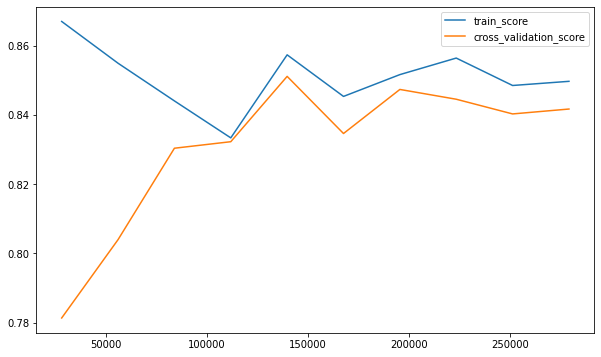

In [ ]:
final_model_AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(class_weight="balanced", criterion="gini",max_depth=2),n_estimators = 10 , random_state=0 ) 
evaluation(final_model_AdaBoost, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:
##################################################################
##################################################################

In [ ]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,15)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_


{'criterion': 'entropy',
 'max_depth': 2,
 'max_features': 5,
 'min_samples_split': 0.1}

test set : 
[[  471    27]
 [45168 47425]]
              precision    recall  f1-score   support

           1       0.01      0.95      0.02       498
           2       1.00      0.51      0.68     92593

    accuracy                           0.51     93091
   macro avg       0.50      0.73      0.35     93091
weighted avg       0.99      0.51      0.67     93091

train set : 
[[  2015    107]
 [180302 189938]]
              precision    recall  f1-score   support

           1       0.01      0.95      0.02      2122
           2       1.00      0.51      0.68    370240

    accuracy                           0.52    372362
   macro avg       0.51      0.73      0.35    372362
weighted avg       0.99      0.52      0.67    372362



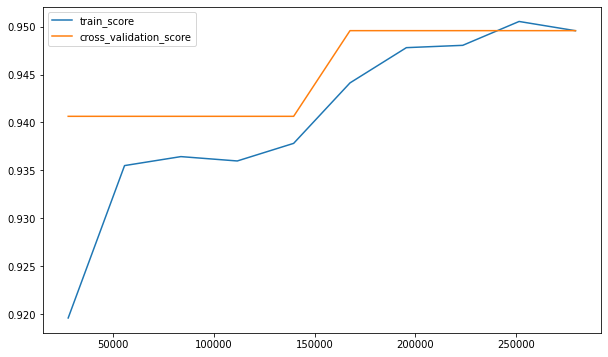

In [21]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="entropy", class_weight = "balanced", max_depth = 2, max_features=5, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [41]:

#importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
20,Don_moyen,0.732512
1,GeoFaz_Scl,0.218157
8,Prenom_Phase_scl_F,0.049330
0,TypeHabi,0.000000
12,Age_F,0.000000
19,Don_max,0.000000
18,Cumul_dons,0.000000
17,Annee_1er_don,0.000000
16,Flag_PA,0.000000
15,codif_RdB,0.000000


[Text(418.5, 453.0, 'GeoFaz_Scl <= 67.5\nentropy = 1.0\nsamples = 372362\nvalue = [186181.0, 186181.0]'),
 Text(209.25, 271.8, 'Don_moyen <= 4.5\nentropy = 0.952\nsamples = 237293\nvalue = [70190.763, 118924.22]'),
 Text(104.625, 90.59999999999997, 'entropy = 0.435\nsamples = 190045\nvalue = [9388.015, 95513.307]'),
 Text(313.875, 90.59999999999997, 'entropy = 0.853\nsamples = 47248\nvalue = [60802.749, 23410.913]'),
 Text(627.75, 271.8, 'Prenom_Phase_scl_F <= 78.5\nentropy = 0.948\nsamples = 135069\nvalue = [115990.237, 67256.78]'),
 Text(523.125, 90.59999999999997, 'entropy = 0.996\nsamples = 76439\nvalue = [44483.396, 38183.599]'),
 Text(732.375, 90.59999999999997, 'entropy = 0.867\nsamples = 58630\nvalue = [71506.84, 29073.181]')]

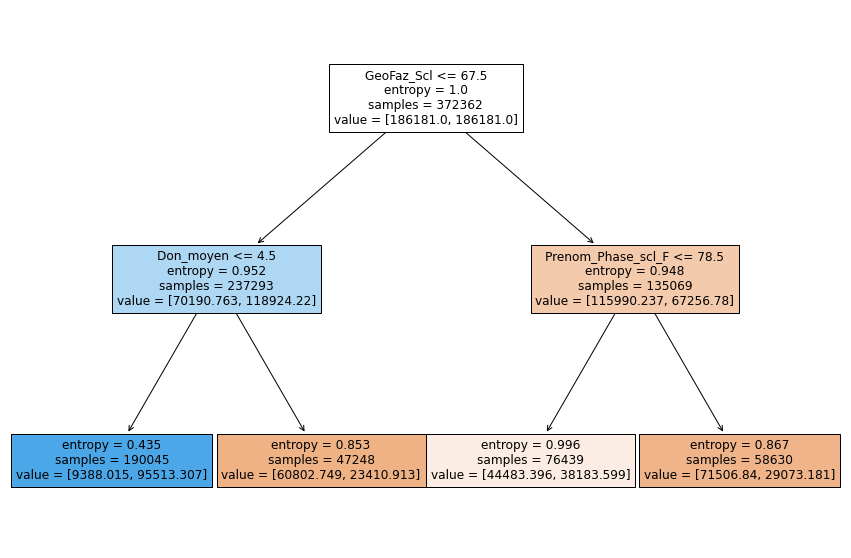

In [43]:
# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)

plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)



In [38]:
data.columns[:-1]

Index(['IDENT', 'TypeHabi', 'GeoFaz_Scl', 'GeoFaz_cl', 'Anciennete',
       'Doublon_ligne', 'Revenus_iris', 'Sexe', 'Prenom_Phase_scl_H',
       'Prenom_Phase_scl_F', 'Prenom_Phase_cl_H', 'Prenom_Phase_cl_F', 'Age_H',
       'Age_F', 'Pays_sud', 'Prenom_effectif', 'codif_RdB', 'Flag_PA',
       'Annee_1er_don', 'Cumul_dons', 'Don_max', 'Don_moyen', 'Vingtiles_ISF'],
      dtype='object')

In [ ]:
##################################################################
##################################################################

In [35]:
#model_AdaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight = { 1 : 178, 2 : 1 }), n_estimators=50, random_state =0 )
#evaluation(model_AdaBoost, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring = "recall")

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_Y_s),
                                                 train_Y_s)
class_weights

array([87.73845429,  0.50286571])

In [ ]:
 462833/2620

176.65381679389313

In [ ]:
1/0.50286571

1.988602483951431

In [ ]:
87.73845429*1.988602483951431

174.4769081391531

In [ ]:
np.linspace(0.1, 1.0, 5)#, endpoint=True) 

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [ ]:
np.linspace(0.1, 1, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
list(range(4,100,5))

[4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94, 99]

In [1]:
list(range(2,20, 2))

[2, 4, 6, 8, 10, 12, 14, 16, 18]

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]